In [1]:
# Import Required Modules

import os
import IPython.display as ipd
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Dropout, BatchNormalization, Rescaling, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, TensorBoard
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop
from tensorflow.keras.models import load_model
from tensorflow import math

import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_PATH = '/kaggle/input/charanetmelspec/CharaNetMelSpec'
# BIRDS = os.listdir(f'{DATA_PATH}/train')
BIRDS = ['Spotted Dove',
 'Swamp Francolin',
 'Rufous-necked Hornbill',
 'Jerdon_s Babbler',
 'Rose-ringed Parakeet',
 'Wood Snipe',
 'Large-billed Crow',
 'Greater Spotted Eagle',
 'Saker Falcon',
 'Rufous Treepie',
 'Indian Spotted Eagle',
 'Satyr Tragopan',
 'Steppe Eagle',
 'House Crow',
 'Long-tailed Duck',
 'Asian Koel',
 'Red-billed Blue Magpie',
 'Pallas_s Fish Eagle',
 'Cheer Pheasant',
 'Rustic Bunting',
 'Grey Treepie',
 'Sarus Crane',
 'Spiny Babbler',
 'Kashmir Flycatcher',
 'Swamp Grass-babbler',
 'Great Slaty Woodpecker',
 'Eastern Imperial Eagle',
 'Black Kite',
 'Black-necked crane',
 'Common Wood Pigeon',
 'Bristled Grassbird',
 'Grey-sided Thrush',
 'House Sparrow',
 'Grey-crowned Prinia',
 'White-throated Bushchat',
 'Himalayan Monal',
 'Black-breasted Parrotbill',
 'Egyptian Vulture',
 'Common Pochard',
 'Common Cuckoo',
 'Slender-billed Babbler']
BATCH_SIZE = 2
IM_SIZE = (128, 128) 
NO_CLASSES = len(BIRDS)

In [3]:
# Load the train, validation and testing dataset

from tensorflow.keras.applications.efficientnet import preprocess_input

# Data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    fill_mode="nearest",
)
train_batches = train_datagen.flow_from_directory(
    os.path.join(DATA_PATH, "train"),
    classes=BIRDS,
    target_size=IM_SIZE,
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE,
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  rescale=1./255)
valid_batches = valid_datagen.flow_from_directory(
    os.path.join(DATA_PATH, "val"),
    classes=BIRDS,
    target_size=IM_SIZE,
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH_SIZE,
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rescale=1./255)
test_batches = test_datagen.flow_from_directory(
    os.path.join(DATA_PATH, "test"),
    classes=BIRDS,
    target_size=IM_SIZE,
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH_SIZE,
)

Found 5414 images belonging to 41 classes.
Found 639 images belonging to 41 classes.
Found 687 images belonging to 41 classes.


In [4]:
!pip install -q optuna

# Optuna

In [5]:
import optuna

from tensorflow.keras.backend import clear_session

In [6]:
def objective(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()
    
    dropout = trial.suggest_categorical("dropout", [0.1, 0.2, 0.3])
    activation = trial.suggest_categorical("activation_function", ['relu', 'sigmoid', 'tanh'])
    dense_layer_size = trial.suggest_categorical("number_of_nodes", [2048, 1024, 512])
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-1)
    
    model = Sequential([

        # First conv block
        Conv2D(16, (3, 3),input_shape=(IM_SIZE[0], IM_SIZE[1], 3)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        # Second conv block
        Conv2D(32, (3, 3)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        # Third conv block
        Conv2D(128, (3, 3)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        # Fourth conv block
        Conv2D(256, (3, 3)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        # Fifth conv block
        Conv2D(512, (3, 3)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(dense_layer_size, activation=activation),  
        Dropout(dropout), 

        # Classification layer
        Dense(NO_CLASSES, activation='softmax')
    ])

    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=lr),
        metrics=["accuracy"],
    )

    # Train the model

    EPOCHS = 2
    history = model.fit(
    train_batches,
    validation_data=valid_batches,
    epochs=EPOCHS)
    score = model.evaluate(valid_batches)
    return score[0]


In [7]:
sam = optuna.samplers.NSGAIISampler(population_size=10, mutation_prob=0.005, crossover_prob=0.8, swapping_prob=0.5, seed=77)
study = optuna.create_study(direction="minimize", sampler=sam)
study.optimize(objective, n_trials=30, n_jobs=1)

print(f"Finished trials: {len(study.trials)}")
trial = study.best_trial
print(f"Best trial: {trial.value}")
print("Parameters: ")
for key, value in trial.params.items():
    print(f"{key}, {value}")

# Model CNN Custom

In [9]:
lr = 0.0001
loss = "categorical_crossentropy"


model = Sequential([
    
    # First conv block
    Conv2D(16, (3, 3),input_shape=(IM_SIZE[0], IM_SIZE[1], 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    # Second conv block
    Conv2D(32, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    # Third conv block
    Conv2D(128, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
           
    # Fourth conv block
    Conv2D(256, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    # Fifth conv block
    Conv2D(512, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    # Sixth conv block)),

    # Global pooling instead of flatten()
#     GlobalAveragePooling2D(), 
    Flatten(),
    Dense(1024, activation='relu'),  
#     Dropout(0.5), 
    Dense(256, activation='relu'),  
    # Classification layer
    Dense(NO_CLASSES, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=lr), loss=loss, metrics=["accuracy"]
)


2023-01-03 16:48:06.596793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 16:48:06.698024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 16:48:06.698837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 16:48:06.700545: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
# model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 126, 126, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 61, 61, 32)        0

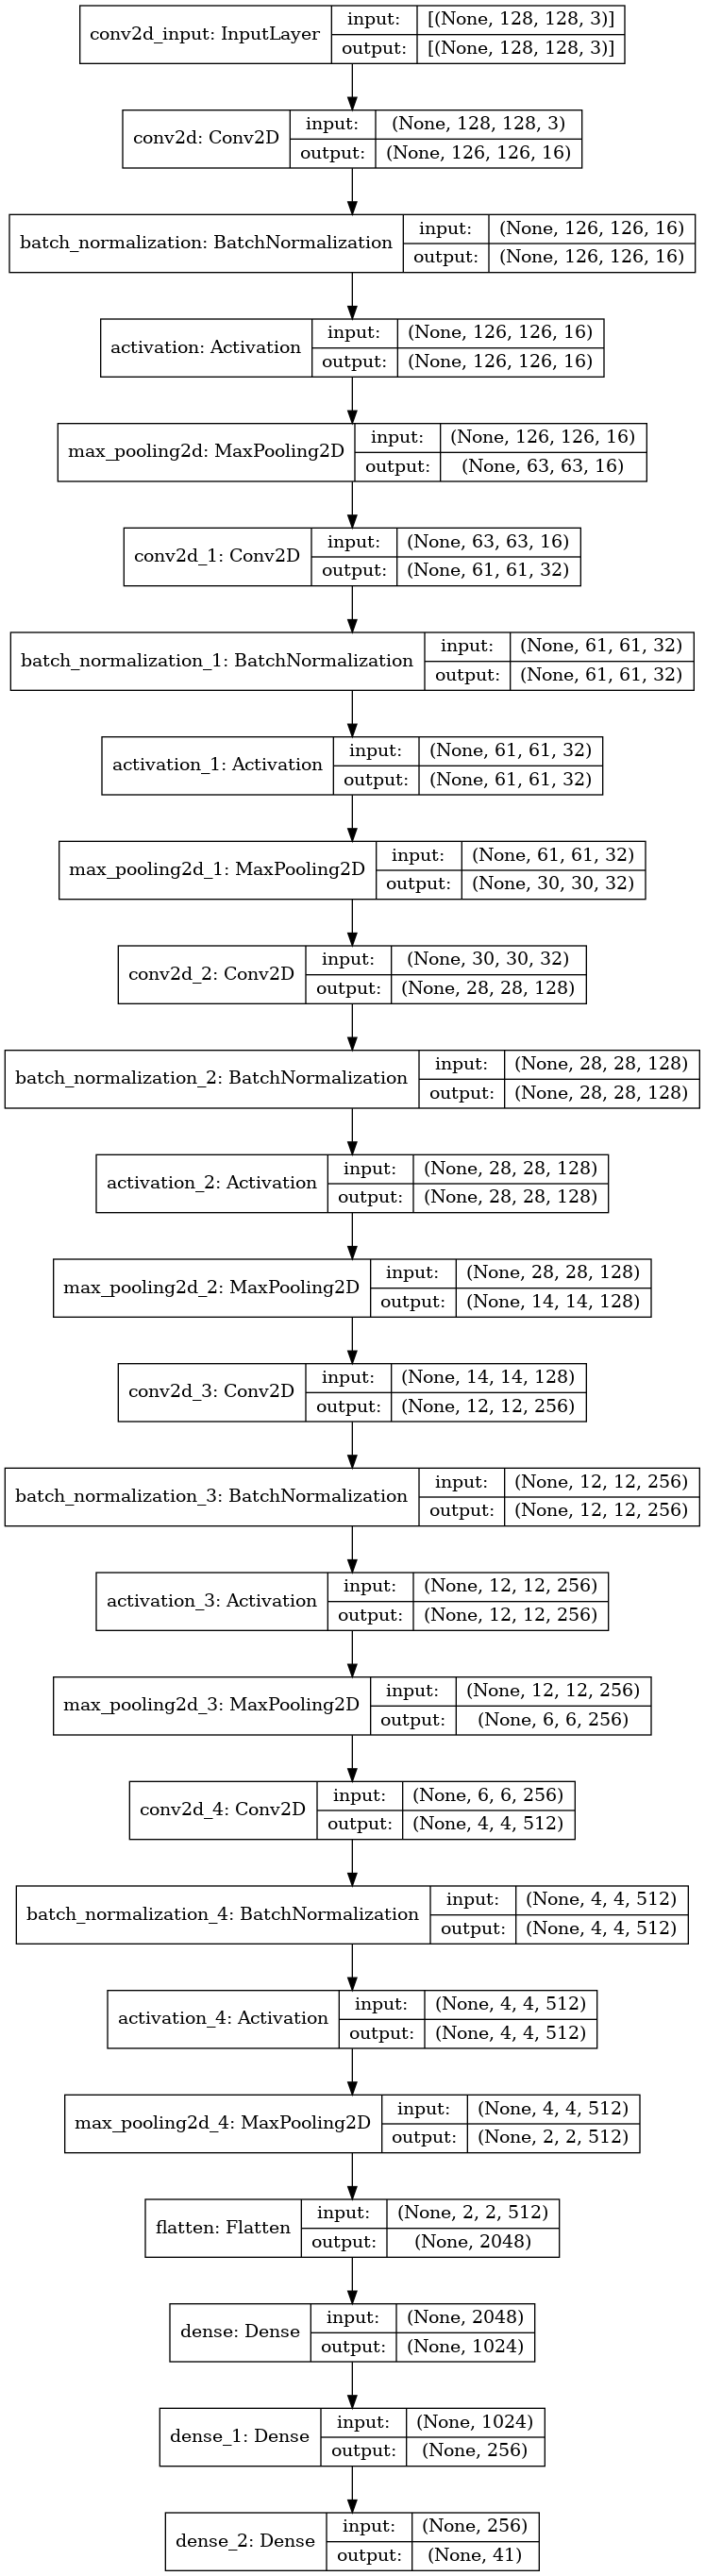

In [11]:
# from keras.utils.vis_utils import plot_model

# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
# Define callbacks

import datetime
# Model checkpoint
logs_directory = 'model/logs/'
checkpoint = ModelCheckpoint(
    r"model/model_checkpoint",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    mode="auto",
    period=1,
)

# ReduceLR = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=3e-4)
# Function for exponential learning rate decay after 5 epochs
def scheduler(epoch, lr):
  decay = -0.1
  if epoch < 5:
    return lr
  else:
    return lr * math.exp((epoch+1)*decay)

lrscheduler = LearningRateScheduler(scheduler)

logdir = os.path.join("logsMelSpecVanilla", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = TensorBoard(log_dir=logdir,histogram_freq=1)

# Early stopping if val_loss does not decrease for 3 epochs
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)

callbacks = [checkpoint, lrscheduler, early_stopping_monitor]

2023-01-03 09:13:10.126777: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-03 09:13:10.127332: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-03 09:13:10.129779: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2023-01-03 09:13:10.356632: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-03 09:13:10.356833: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [17]:
# Train the model

EPOCHS = 50
history = model.fit(
    train_batches,
    validation_data=valid_batches,
    epochs=EPOCHS,
    callbacks= callbacks)

2023-01-03 09:13:14.380562: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2023-01-03 09:13:16.203866: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2707/2707 [==============================] - 78s 26ms/step - loss: 3.0202 - accuracy: 0.1627 - val_loss: 2.4094 - val_accuracy: 0.2786


2023-01-03 09:14:33.436388: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/50
2707/2707 [==============================] - 56s 21ms/step - loss: 2.4846 - accuracy: 0.2806 - val_loss: 2.1167 - val_accuracy: 0.3537
Epoch 3/50
2707/2707 [==============================] - 58s 22ms/step - loss: 2.2310 - accuracy: 0.3521 - val_loss: 2.0119 - val_accuracy: 0.4335
Epoch 4/50
2707/2707 [==============================] - 58s 21ms/step - loss: 2.0251 - accuracy: 0.4078 - val_loss: 1.8559 - val_accuracy: 0.4366
Epoch 5/50
2707/2707 [==============================] - 55s 20ms/step - loss: 1.8833 - accuracy: 0.4352 - val_loss: 1.6950 - val_accuracy: 0.4930
Epoch 6/50
2707/2707 [==============================] - 56s 21ms/step - loss: 1.6582 - accuracy: 0.5116 - val_loss: 1.5186 - val_accuracy: 0.5696
Epoch 7/50
2707/2707 [==============================] - 57s 21ms/step - loss: 1.5031 - accuracy: 0.5547 - val_loss: 1.3091 - val_accuracy: 0.6338
Epoch 8/50
2707/2707 [==============================] - 55s 20ms/step - loss: 1.3926 - accuracy: 0.5912 - val_loss: 1.3052 -

In [87]:
model.save('./model/CNMelSpecVanilla_Model')
model_loaded = load_model('./model/CNMelSpecVanilla_Model')
model_chkp = load_model('./model/model_checkpoint')
model_loaded.evaluate(test_batches)

344/344 [==============================] - 4s 12ms/step - loss: 1.2585 - accuracy: 0.6565


[1.2585008144378662, 0.6564774513244629]

In [132]:
# For TensorBoard
log_filepath = '/kaggle/working/logsMelSpecVanilla'

# # !tensorboard --logdir=log_filepath --host localhost --port 8088

# %load_ext tensorboard
# %tensorboard --logdir log_filepath

# Saving log files locally
import shutil

# output_filename = log_filepath.split('/')[-1]
output_filename = "logsfile"
shutil.make_archive(output_filename, 'zip', log_filepath)

'/kaggle/working/logsfile.zip'

In [88]:
import shutil

dir_name = '/kaggle/working/model/CNMelSpecVanilla_Model'
output_filename = dir_name.split('/')[-1]

shutil.make_archive(output_filename, 'zip', dir_name)

'/kaggle/working/CNMelSpecVanilla_Model.zip'

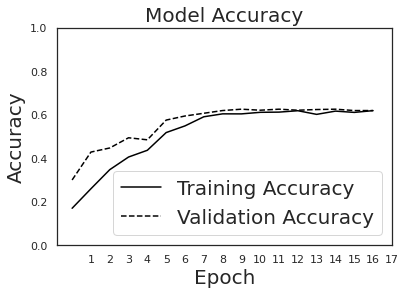

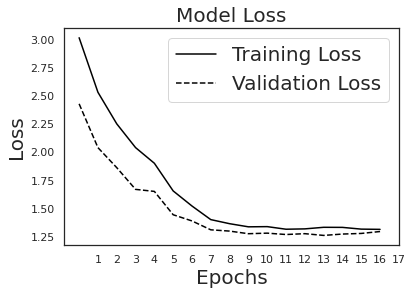

In [93]:
# Accuracy and Loss 

from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set()
sns.set_style(style='white')

# Accuracy vs epochs plot
def accuracy_plot(model, history):

    annot_size = 20
    fig_size = (10, 10)
    epochs = len(history.history['accuracy'])
    
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='black')
    plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', linestyle='dashed', color='black')
    
    plt.title('Model Accuracy', fontsize=annot_size)
    plt.xlabel('Epoch', fontsize=annot_size)
    plt.ylabel('Accuracy', fontsize=annot_size)
    plt.ylim([0, 1])
    plt.xticks(list(range(1, epochs+1)))
    plt.legend(loc='lower right', fontsize=annot_size)
    plt.savefig('accuracy.jpg', bbox_inches='tight')
    plt.show()

# Loss vs epochs plot
def loss_plot(model, history):
    annot_size = 20
    fig_size = (10, 10)
    epochs = len(history.history['loss'])
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(loss, label='Training Loss', color='black')
    plt.plot(val_loss, label = 'Validation Loss', linestyle='dashed', color='black')
    
    plt.title('Model Loss', fontsize=annot_size)
    plt.xlabel('Epochs', fontsize=annot_size)
    plt.ylabel('Loss', fontsize=annot_size)
#     plt.ylim([0, 0.85])
    plt.xticks(list(range(1, epochs+1)))
    plt.legend(loc='upper right', fontsize=annot_size)
    plt.savefig('loss.jpg', bbox_inches='tight')
    plt.show()

accuracy_plot(model, history)
loss_plot(model, history)

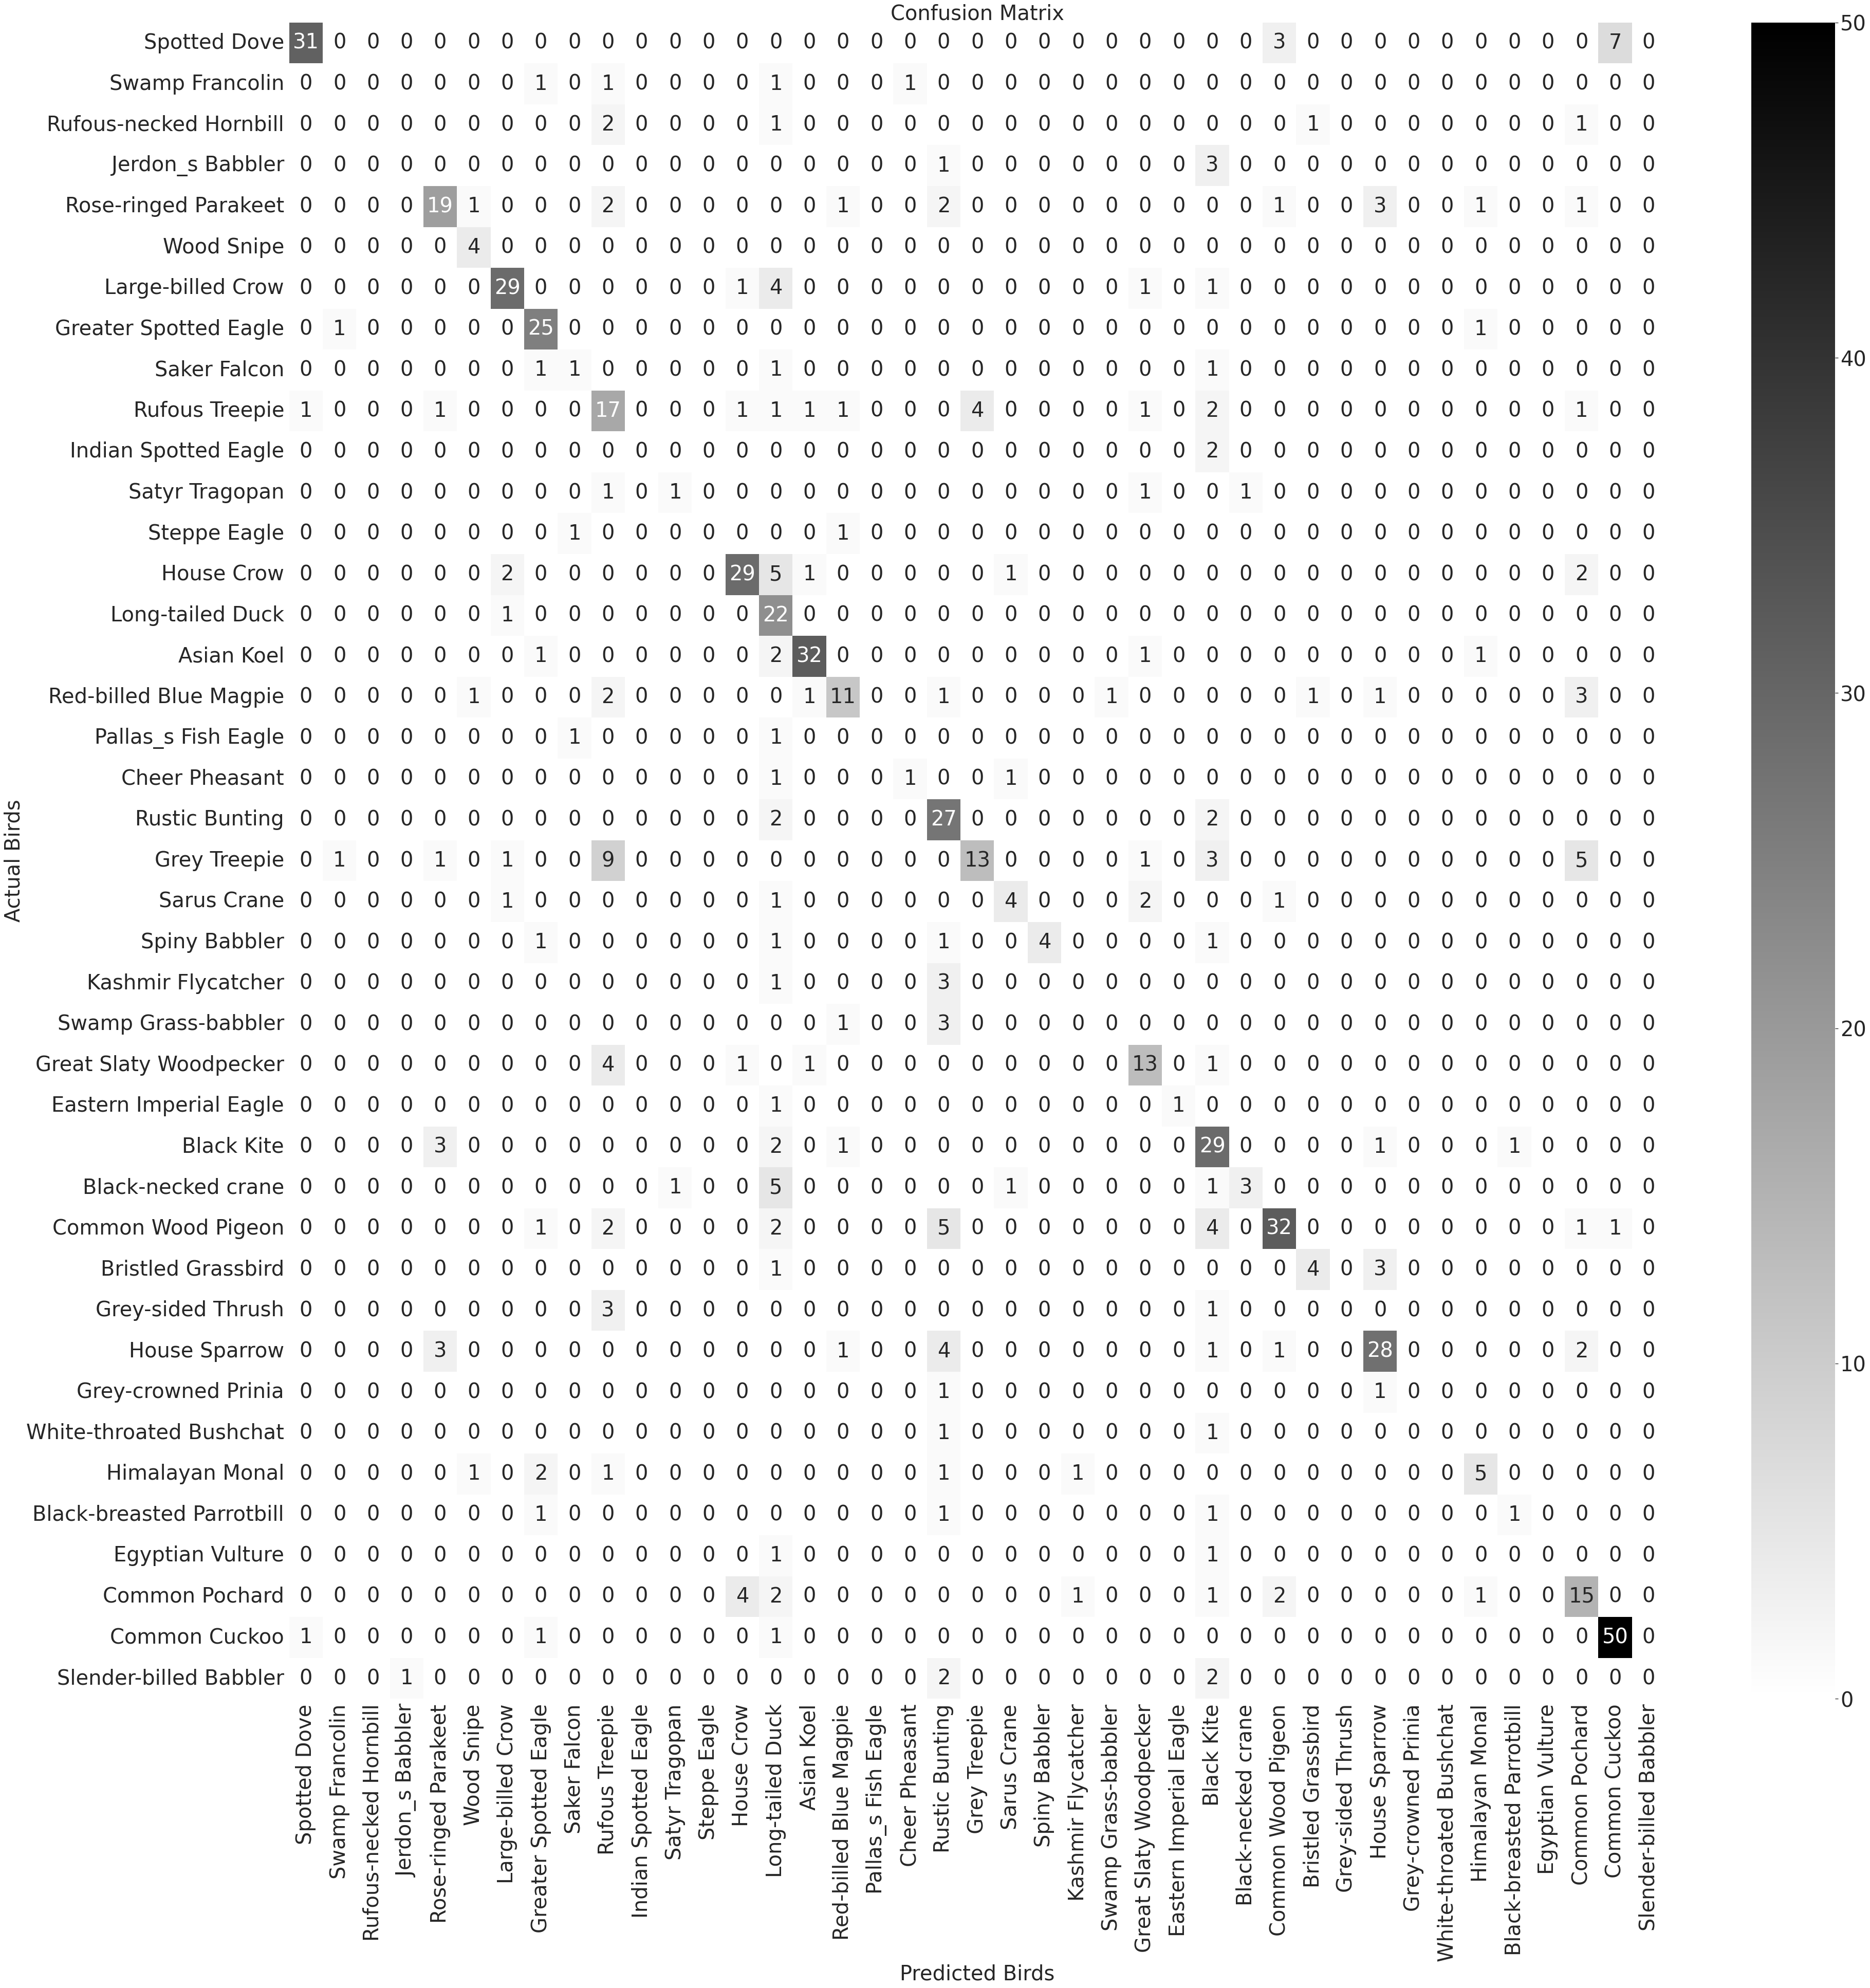

In [94]:
# Confusion Matrix

def confusion_matrix_plot(model, test_batches):
    
    annot_size = 40
    fig_size = (60, 60)

    preds = model_loaded.predict(x=test_batches)
    y_preds = np.argmax(preds, axis=-1)
    y_true = test_batches.classes

    confuse = confusion_matrix(y_true, y_preds)

    plt.rcParams["font.family"] = "Times New Roman"
    sns.set(rc = {'figure.figsize':fig_size, 'xtick.labelsize':annot_size, 'ytick.labelsize':annot_size})
    # plt.rcParams['figure.figsize'] = fig_size
    conf_df = pd.DataFrame(confuse)
    conf_df.index = BIRDS
    conf_df.columns = BIRDS
    sns.heatmap(conf_df, annot=True, cmap='binary', annot_kws={'size': annot_size})
    plt.title('Confusion Matrix', fontdict={'fontsize':annot_size}) 
    plt.xlabel('Predicted Birds', fontdict={'fontsize':annot_size})
    plt.ylabel('Actual Birds', fontdict={'fontsize':annot_size})
    plt.savefig('Confusion Matrix.png', dpi=200, format='png', bbox_inches='tight')

confusion_matrix_plot(model, test_batches)

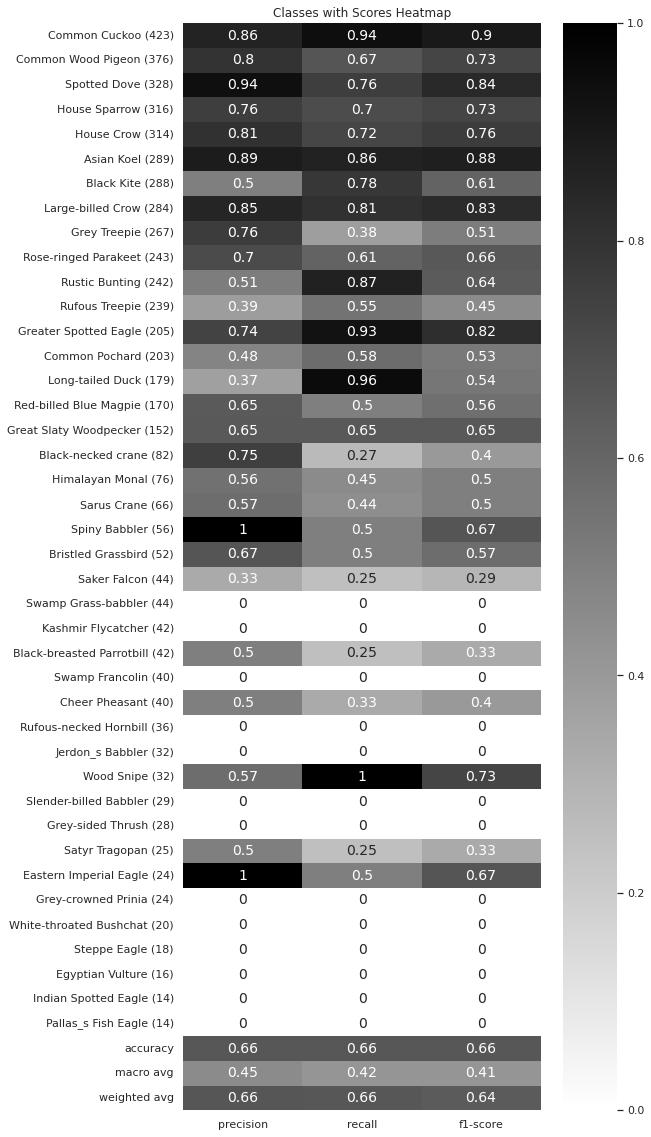

In [95]:
# Classes with scores heatmap

def class_scores(classes_dir, model, test_batches):
    
    birds_train_count = {}
    annot_size = 14
    fig_size = (8,20)
    
    for f in os.listdir(classes_dir):
        birds_train_count[f] = len(os.listdir(os.path.join(train_dir, f)))

    birds_train_count = dict(sorted(birds_train_count.items(), key= lambda x: x[1], reverse=True))

    preds = model.predict(x=test_batches)
    y_preds = np.argmax(preds, axis=-1)
    y_true = test_batches.classes
    clf_report = classification_report(y_true, y_preds, output_dict=True)
    cls_df = pd.DataFrame(clf_report).iloc[:-1, :].T
    acc_to_counts = [str(BIRDS.index(bird)) for bird in [k for k in birds_train_count.keys()]] + ['accuracy', 'macro avg', 'weighted avg']

    cls_df = cls_df.reindex(acc_to_counts)
    y_label = [f"{k} ({v})" for k, v in birds_train_count.items()] + ['accuracy', 'macro avg', 'weighted avg']
    cls_df.index = y_label

    sns.set(rc = {'figure.figsize':fig_size})
    sns.heatmap(cls_df, annot=True, annot_kws={'size': annot_size}, cmap='binary')
    plt.title('Classes with Scores Heatmap') 
    plt.savefig('Classes with Scores Heatmap.png', dpi=200, format='png', bbox_inches='tight')

train_dir = '/kaggle/input/charanetmelspec/CharaNetMelSpec/train'

class_scores(train_dir, model_loaded, test_batches)

In [96]:
# Inference

# !pip install pydub
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Rescaling

from pydub import AudioSegment
import math
import shutil

import warnings
warnings.filterwarnings("ignore")

# # Turn interactive plotting off
# import matplotlib
# matplotlib.use('Agg')
# plt.ioff()

# Variables for feature extraction
SAMPLE_RATE = 32000
SPEC_SHAPE = (48, 128) # height x width
SIGNAL_LENGTH = 10
N_FFT = 1024         
HOP_SIZE =  int(SIGNAL_LENGTH * SAMPLE_RATE / (SPEC_SHAPE[1] - 1))      
N_MELS = SPEC_SHAPE[0]   
WIN_SIZE = 1024      
WINDOW_TYPE = 'hann' 
FEATURE = 'mel'      
FMIN = 500
FMAX = 12500

def SplitAudio(audio_file, sec_to_split=10):
    
    validAudio = lambda audio, amp_threshold: True if audio.max > amp_threshold else False
    
    global temp_n
    temp_n = 0
    mili=1000
    export_folder = f'./inference/tmp'
    export_name = audio_file.split('/')[-1]
    exportFormat = 'mp3'
    try:
        audio = AudioSegment.from_mp3(audio_file)
    except:
        print("File handled: ", audio_file)
        extension = audio_file.split('.')[-1]
        if extension == 'wav':
            audio = AudioSegment.from_wav(audio_file)
        elif extension == 'ogg':
            audio = AudioSegment.from_ogg(audio_file)
    th = audio.max//2
 
    duration = math.floor(audio.duration_seconds)
    splits = np.arange(0, duration, sec_to_split)

    if duration > sec_to_split:
        rem = duration % sec_to_split
        n_splits = round(duration / sec_to_split)
        for n in range(n_splits-1): # Except last splitted file
            newAudio = audio[splits[n]*mili:splits[n+1]*mili]
            temp_n = n
            if validAudio(newAudio, th):
                newAudio.export(f'{export_folder}/{export_name}{n}.{exportFormat}', format=exportFormat)
        
        # For the last splitted file
        if rem <= sec_to_split//2:
            n = temp_n
            # If remaining  audio is small enough, don't separate
            newAudio = audio[splits[n+1]*mili:duration*mili]
            if validAudio(newAudio, th):
                newAudio.export(f'{export_folder}/{export_name}{n+1}.{exportFormat}', format=exportFormat)

        else:
            n = temp_n
            # If remaining audio is big enough, make it separate file
            newAudio = audio[splits[n+1]*mili:duration*mili]
            if validAudio(newAudio, th):
                newAudio.export(f'{export_folder}/{export_name}{n+1}.{exportFormat}', format=exportFormat)

    else:
        if validAudio(audio, th):
            audio.export(f'{export_folder}/{export_name}original.{exportFormat}', format=exportFormat)

def create_features(inference_data_path):
    
    # Find the list of all 10 sec splitted audio files
    audio_files = [f for f in os.listdir(inference_data_path) if f.split('.')[-1]=='mp3']
    count = 0
    for aud in audio_files:

        signal, sr = librosa.load(os.path.join(inference_data_path, aud),duration=10) # sr = sampling rate
        # Plot mel-spectrogram
        S = librosa.feature.melspectrogram(y=signal,
                                           sr=SAMPLE_RATE,
                                            n_fft=N_FFT,
                                            hop_length=HOP_SIZE, 
                                            n_mels=N_MELS, 
                                            fmin=FMIN, 
                                            fmax=FMAX) 

        fig = plt.figure(figsize=(10, 4))
        mel_spec = librosa.power_to_db(S, ref=np.max) 
        librosa.display.specshow(mel_spec, fmin=FMIN,y_axis='linear')
        plt.axis(False)
        plt.tight_layout()
        # plt.show()
        count += 1
        plt.savefig(f'{inference_data_path}/inf{count}.jpg')
        plt.close(fig)
        
def preprocess_img(image_dir, img_size):
    img_width, img_height = img_size[0], img_size[1]
    img = image.load_img(image_dir, target_size = (img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    norm = Rescaling(1./255)
    img = norm(img)
    img = preprocess_input(img) 
    return img

def prediction(model_dir, inference_data_path, img_size):
    # List of feature images
    feat = [os.path.join(inference_data_path, f) for f in os.listdir(inference_data_path) if f.split('.')[-1]=='jpg']
    results = []
    for m in feat:
        model_loaded = load_model(model_dir)
        img = preprocess_img(m, img_size)
        output = BIRDS[np.argmax(model_loaded.predict(img), axis=-1)[0]]
        results.append(output)
    result = max(results)
    
    # Remove the temporary splitted audio and mfcc images
    for i in os.listdir(inference_data_path):
        os.remove(os.path.join(inference_data_path, i))
    return results

In [100]:
inference_data_path = './inference/tmp'
raw_data_path = '/kaggle/input/chara-net-demo/CharaNetDemo/test/Long-tailed Duck/XC522505 original.mp3'
model_dir = '/kaggle/working/model/CNMelSpecVanilla_Model'
img_size = (128, 128)

if 'inference' not in os.listdir('./'):
    os.makedirs(inference_data_path)

SplitAudio(raw_data_path)
create_features(inference_data_path)
result = prediction(model_dir, inference_data_path, img_size)
print(max(result))

Long-tailed Duck
